# Лабораторная 5: Проверка гипотез 2

## Задание 1: сравнение критерия знаков и критерия ранговых знаков (Уилкоксона)


### Пункт 1: критерий знаков

Будем рассматривать выборку $X: x_j \in N(0, 7), n = 20$ и сравнивать ее с
а) $Y: y_j = 5x_j + \epsilon_j, \epsilon_j \in Uniform[-10, 10]$
б) $Y: y_j = 5x_j + \eta_j, \eta_j \in expon(20)$

Text(0.5, 1.0, 'With exponential error')

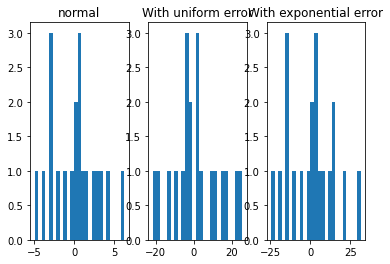

In [1]:
import numpy as np
import scipy.stats as st
from utils.noise import get_with_noise
from matplotlib import pyplot as plt

distr = np.random.normal(loc=0, scale=7 ** 0.5, size=20)
distr_a = get_with_noise(distr, lambda: st.uniform.rvs(loc=-10, scale=20), epsilon=1, factor=5)
distr_b = get_with_noise(distr, lambda: st.expon.rvs(scale=1 / 20), epsilon=1, factor=5)

fig, (plt, plt_a, plt_b) = plt.subplots(1, 3)
plt.hist(distr, bins=25)
plt.set_title("normal")
plt_a.hist(distr_a, bins=25)
plt_a.set_title("With uniform error")
plt_b.hist(distr_b, bins=25)
plt_b.set_title("With exponential error")

Теперь нужно посчитать числа m (количество " - " [$x_i < y_i \rightarrow " - "$]) и k (количество " + " [$x_i > y_i \rightarrow " + "$])

In [2]:
def count_signs(distr1, distr2):
    m = 0
    for i in range(distr1.size):
        if distr1[i] < distr2[i]:
            m += 1
    k = distr.size - m
    return m, k

In [3]:
m, k = count_signs(distr, distr_a)
print(m, k)

11 9


Теперь рассмотрим величину $w = min(m, k) \sim B(n, \frac12)$
Будем использовать левый хвост биномиального распределения в качестве статистики (такую статистику можно использовать только при $n \leq 25$): $t = \frac{1}{2^n} \sum_{j = 0}^w C_n^j$
Если $H_0 = (p = \frac12)$ выполняется, то $t \in [\frac\alpha2, 1 - \frac\alpha2]$ (квантили Биномиального распределения)

In [4]:
from math import comb

w = min(m, k)
t = 1 / 2 ** distr.size * sum([comb(distr.size, j) for j in range(w)])
error = 0.05
a = error / 2
b = 1 - a
print(f"t = {t}, [{a}; {b}]")

t = 0.2517223358154297, [0.025; 0.975]


Проделаем всё то же самое для пункта б (для шума из экпоненциального распределения):

In [5]:
m, k = count_signs(distr, distr_b)
print(m, k)
w = min(m, k)
t = 1 / 2 ** distr.size * sum([comb(distr.size, j) for j in range(w)])
error = 0.05
a = error / 2
b = 1 - a
print(f"t = {t}, [{a}; {b}]")

12 8
t = 0.13158798217773438, [0.025; 0.975]


### Пункт 2: критерий ранговых знаков

Создадим такие же выборки только побольше (n = 100).
Находим разности между элементами выборок X и Y, упорядочиваем это множество и присваиваем каждой разности ранг (я просто пронумеровал):
$|x_j - y_j| \leq |x_{j + 1} - y_{j + 1}| \leq ... \leq |x_j_n - y_j_n|$, у каждой разности свой ранг R_j. Я ввел R_1 = 1 и т. д.

In [6]:
distr = np.random.normal(loc=0, scale=7 ** 0.5, size=100)
distr_a = get_with_noise(distr, lambda: st.uniform.rvs(loc=-10, scale=20), epsilon=1, factor=5)
distr_b = get_with_noise(distr, lambda: st.expon.rvs(scale=1 / 20), epsilon=1, factor=5)



Теперь посчитаем оценку (такую можно использовать только при $n \leq 25$) $t = \sum_{j = 1}^{n} = sign(x_j - y_j)R_j$
$t\sim$ распределение Уилкоксона с параметрами $\mu = 0, \sigma = \sqrt{\frac{n(n + 1)(2n + 1)}{6}}$
$H_0 \rightarrow [-W_{\alpha, n_k}, W_{\alpha, n_k}], W_{\alpha, n_k}$ - критическое значение (он же квантиль Уилкоксона)

Но мы будем сразу рассматривать ассимптотический критерий:
$\frac{t}{\sqrt{\frac{n(n + 1)(2n + 1)}{6}}} \sim N(0, 1)$
$H_0 \rightarrow [N_{\alpha / 2}; N_{1 - \alpha / 2}]$

In [7]:
from numpy import sign


def criteria_asympt_signs(distr1, distr2):
    m, k = count_signs(distr1, distr2)
    w = min(m, k)
    t = (w - distr1.size / 2) / (distr1.size / 4) ** 0.5
    a = st.norm.ppf(q=error / 2)
    print(f"t = {t}, [{a}; {-a}]")


def criteria_asympt_rang_signs(distr1, distr2):
    differences = [distr1[i] - distr2[i] for i in range(distr1.size)]
    differences.sort(key=abs)
    n = len(differences)
    # R_i = i + 1, because i begins from 0
    t = sum([sign(differences[i]) * (i + 1) for i in range(n)])
    t_assyptotic = t / (n * (n + 1) * (2 * n + 1) / 6) ** 0.5
    a = st.norm.ppf(q=error / 2)
    print(f"t = {t_assyptotic} [{a}; {-a}]")

### Пункт 3: Сравнение ассимптотического критерия знаков и ассимтотического критерия ранговых знаков:

In [8]:
print("With uniform noise: ")
print("Symple: ")
criteria_asympt_signs(distr, distr_a)
print("Rang: ")
criteria_asympt_rang_signs(distr, distr_a)

print("With exp noise: ")
print("Symple: ")
criteria_asympt_signs(distr, distr_b)
print("Rang: ")
criteria_asympt_rang_signs(distr, distr_b)



With uniform noise: 
Symple: 
t = -1.6, [-1.9599639845400545; 1.9599639845400545]
Rang: 
t = 1.8876403391399215 [-1.9599639845400545; 1.9599639845400545]
With exp noise: 
Symple: 
t = -1.4, [-1.9599639845400545; 1.9599639845400545]
Rang: 
t = 1.378768262286172 [-1.9599639845400545; 1.9599639845400545]


### Пункт 4: посчитать коэф корреляции пирсона и ранговый коэф корреляции кендала и проверить коррелированность по обоим критериям

Посчитаем коэффициент корелляции Кендэлла и проверим гипотезу $H_0 = (r = 0)$:

In [9]:
r = st.kendalltau(distr, distr_a)[0]
print(r)
t = r / (2 * (2 * distr.size + 5) / (9 * distr.size * (distr.size - 1))) ** 0.5
a = st.norm.ppf(q=error / 2)
print(f"t = {t}, [{a}; {-a}]")

0.6816161616161617
t = 10.048166041533458, [-1.9599639845400545; 1.9599639845400545]


Теперь тоже самое для коэффициента пирсона (он подчиняется распределению Стьюдента $t_{n-2}$):

In [10]:
p = st.pearsonr(distr, distr_a)[0]
t = p / (1 - p ** 2) ** 0.5
a = st.t.ppf(q=error / 2, df=distr.size - 2)
b = st.t.ppf(q=1 - error / 2, df=distr.size - 2)
print(f"t = {t}, [{a}; {b}]")

t = 1.8700297321425816, [-1.9844674544266925; 1.984467454426692]


Вынесем сравнение двух критериев в отдельную функцию и сравним их работу для пункта а и б.

In [11]:
def compare_correlation(distr1, distr2):
    print("Kendell: ")
    r = st.kendalltau(distr1, distr2)[0]
    t = r / (2 * (2 * distr1.size + 5) / (9 * distr2.size * (distr1.size - 1))) ** 0.5
    a = st.norm.ppf(q=error / 2)
    print(f"t = {t}, [{a}; {-a}]")
    print("Pearson: ")
    p = st.pearsonr(distr1, distr2)[0]
    t = p / (1 - p ** 2) ** 0.5
    a = st.t.ppf(q=error / 2, df=distr1.size - 2)
    b = st.t.ppf(q=1 - error / 2, df=distr1.size - 2)
    print(f"t = {t}, [{a}; {b}]")


print("Uniform noise: ")
compare_correlation(distr, distr_a)

print()
print("Exponential noise: ")
compare_correlation(distr, distr_b)

Uniform noise: 
Kendell: 
t = 10.048166041533458, [-1.9599639845400545; 1.9599639845400545]
Pearson: 
t = 1.8700297321425816, [-1.9844674544266925; 1.984467454426692]

Exponential noise: 
Kendell: 
t = 14.711896930994454, [-1.9599639845400545; 1.9599639845400545]
Pearson: 
t = 204.80830526204824, [-1.9844674544266925; 1.984467454426692]


### Пункт 5: Проверка автокорреляции

($H_0 = ${автокорреляция отсутствует $p_{auto} = 0$})

$n = 200$, t - статистика автокорреляции
а) Проверить для выборки: $n = 200, N(5, 7)$
б) Проверить для выборки: $n = 199, y_j = x_j + 0.1 * x_{j + 1}$

In [12]:
distr_a = np.random.normal(loc=5, scale=7 ** 0.5, size=200)
distr_b = [distr_a[i] + 0.1 * distr_a[i + 1] for i in range(distr_a.size - 1)]


def check_autocorrelation(distr):
    n = len(distr)
    counter = n * sum([distr[i] * distr[i + 1] for i in range(n - 1)]) - sum(distr) ** 2 + n * distr[0] * distr[n - 1]
    delimiter = n * sum([distr[i] ** 2 for i in range(n)]) - sum(distr) ** 2
    t = counter / delimiter
    # Проведем перенормировку
    z = (t + 1 / (n + 1)) / (n * (n - 3) / ((n + 1) * (n - 1) ** 2)) ** 0.5
    a = st.norm.ppf(q=error / 2)
    print(f"z = {z}, [{a}; {-a}]")


print("Without autocorrelation, H should be correct")
check_autocorrelation(distr_a)

print("With autocorrelation, H should be incorrect")
check_autocorrelation(distr_b)

Without autocorrelation, H should be correct
z = 0.007535194415569017, [-1.9599639845400545; 1.9599639845400545]
With autocorrelation, H should be incorrect
z = 1.2169352089999899, [-1.9599639845400545; 1.9599639845400545]


### Пункт 6: Критерий Хсу
Гипотеза $H_0 = $(Дисперсии $X_j$ одинаковы) против $H_1 = $(Дисперсии $X_j$ разные [начиная с некоторого номера изменилась])

а) Проверить исходную выборку $X_1: n = 200, N(5, 7)$
б) Делим пополам $X_1$ и вторую половину умножаем на 1.5, потом обратно объединяем, критерием Хсу проверяем

In [13]:
def criteria_xu(distr):
    distr.sort()
    n = distr.size
    median = np.median(distr)
    t = sum([(i - 1) * (distr[i] - median) ** 2 for i in range(n)]) / (
            (n - 1) * sum([(distr[i] - median) ** 2 for i in range(n)]))
    # Нормируем
    z = (t - 1 / 2) / ((n + 1) / (6 * (n - 1) * (n + 2))) ** 0.5
    a = st.norm.ppf(q=error / 2)
    print(f"t = {z}, [{a}; {-a}]")  # Пункт а

print("With same dispersion, H0 should be true")
distr_a = np.random.normal(loc=5, scale=7 ** 0.5, size=200)
criteria_xu(distr_a)

print("With not same dispersion, H0 should be wrong")
distr_b = np.random.normal(loc=5, scale=7 ** 0.5, size=200)
for i in range(distr_b.size // 2, distr_b.size):
    distr_b[i] *= 1.5
criteria_xu(distr_b)

With same dispersion, H0 should be true
t = 2.302778626297437, [-1.9599639845400545; 1.9599639845400545]
With not same dispersion, H0 should be wrong
t = -0.27814272286590114, [-1.9599639845400545; 1.9599639845400545]
